Here I explore the performance of bayesian hierarchical models with preliminary dimensional reduction via PCA.

In [1]:
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from seaborn import heatmap
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
import pymc3 as pm
import cmocean.cm as cm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.titlesize'] = 20
rcParams['font.size'] = 16

In [3]:
def PlotPCARes(pca_machine, threshold=0.85, alpha=1, num_pca_disp=None):
    """This function plots PCA results"""
    f, ax = pl.subplots(figsize=(12, 10))
    #n = data.shape[1]
    cum_expl_var = np.cumsum(pca_machine.explained_variance_ratio_)
    if num_pca_disp is None:
        num_pca_disp = np.argmax(cum_expl_var>0.999) + 1
    
    ax.bar(range(1, num_pca_disp+1),
           pca_machine.explained_variance_ratio_[:num_pca_disp],
           align='center', color='skyblue',
          label='PC explained_variance');
    ax.step(range(1, num_pca_disp+1),
            np.cumsum(pca_machine.explained_variance_ratio_[:num_pca_disp]),
            where='mid',
           label='cumulated variance')
    ax.hlines(threshold, 0, num_pca_disp+2, linestyles='--', linewidth=2,
                 label='selection cutoff: %.2f' % threshold)
    ax.set_xticks(np.arange(1, num_pca_disp+1))
    ax.set_xticklabels(['PC%d' %i for i in range(1, num_pca_disp+1)],
                       rotation=45)
    ax.set_xlim((0.5, 0.5+num_pca_disp))
    ax.set_ylim((0, 1))
    ax.set_title('PCA Explained Variance')
    ax.legend(loc='center right')
    
def PlotPCAvsFeatures(pca_data, df_features, num_pc=None, df_target=np.empty(0)):
    if num_pc is None:
        num_pc = pca_data.shape[1]
    df_pca = pd.DataFrame(pca_data[:, :num_pc],
                          columns=['PC%d' % (pci+1) for pci in range(num_pc)],
                          index=df_features.index)
    to_drop = df_features.columns.tolist()
    if df_target.any().any():
        df_feat_pca = pd.concat((df_features, df_target, df_pca), axis=1)
        to_drop.extend(df_target.columns.tolist())
    else:
        df_feat_pca = pd.concat((df_features, df_pca), axis=1)
    pca_corr = df_feat_pca.corr()
    pca_corr.drop(to_drop, axis=0, inplace=True)
    pca_corr.drop(df_pca.columns.tolist(), axis=1, inplace=True)
    f, ax = pl.subplots(figsize=(len(to_drop), pc_num))
    heatmap(pca_corr, ax=ax, annot=True, cmap=CM.balance, vmin=-1, vmax=1);

    
def ScaleAndPCA(df, visualize=True, var_threshold=0.95, alpha=0.6, verbose=True):
    pca = PCA()
    scaler = StandardScaler()
    features = df.values
    features_sc = scaler.fit_transform(features)
    pca=PCA()
    pcadata = pca.fit_transform(features_sc)
    cum_expl_var = np.cumsum(pca.explained_variance_ratio_)
    num_pca_thresh = np.argmax(cum_expl_var>var_threshold) + 1
    if verbose:
        print("explained variance, by PC")
        print(pca.explained_variance_)
        print('-' * 80)
        print("relative explained variance by PC")
        print(pca.explained_variance_ratio_)
        print('-' * 80)
    print("min. # of PCs accounting for req. var. thresh. (%.2f) requested %d" 
          % (var_threshold, num_pca_thresh))
    if visualize:
        PlotPCARes(pca, threshold=var_threshold, alpha=alpha)
    return scaler, pcadata, pca, num_pca_thresh

In [4]:
df_ = pd.read_pickle('./pickleJar/d_nomad_aop_with_longhurst.pkl')

In [5]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 30 columns):
id              4459 non-null object
datetime        4459 non-null datetime64[ns]
doy             4459 non-null float64
lat             4459 non-null float64
lon             4459 non-null float64
Province        4459 non-null object
ProvCode        4459 non-null object
ProvCat         4459 non-null int64
Biome           4459 non-null object
BiomCat         4459 non-null int8
etopo2          4459 non-null float64
oisst           4459 non-null float64
woa_sst_mean    2516 non-null float64
woa_sst_se      2516 non-null float64
woa_sal_mean    2511 non-null float64
woa_sal_se      2511 non-null float64
rrs411          4293 non-null float64
rrs443          4456 non-null float64
rrs489          4422 non-null float64
rrs510          4207 non-null float64
rrs555          4453 non-null float64
rrs670          3905 non-null float64
mxBl            4459 non-null float64
mxBlId          4459 

In [6]:
rrs_cols = df_.filter(regex='rrs').columns.tolist()
df_.dropna(inplace=True, subset=rrs_cols)

In [7]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3603 entries, 0 to 4458
Data columns (total 30 columns):
id              3603 non-null object
datetime        3603 non-null datetime64[ns]
doy             3603 non-null float64
lat             3603 non-null float64
lon             3603 non-null float64
Province        3603 non-null object
ProvCode        3603 non-null object
ProvCat         3603 non-null int64
Biome           3603 non-null object
BiomCat         3603 non-null int8
etopo2          3603 non-null float64
oisst           3603 non-null float64
woa_sst_mean    2143 non-null float64
woa_sst_se      2143 non-null float64
woa_sal_mean    2138 non-null float64
woa_sal_se      2138 non-null float64
rrs411          3603 non-null float64
rrs443          3603 non-null float64
rrs489          3603 non-null float64
rrs510          3603 non-null float64
rrs555          3603 non-null float64
rrs670          3603 non-null float64
mxBl            3603 non-null float64
mxBlId          3603 

In [8]:
def PlotCrossCorr(pca_data_):
    df_rrs = df_.filter(regex='rrs')
    rrs_cols = df_rrs.columns.tolist()
    pc_num=6
    df_pca = pd.DataFrame(pca_data_[:,:pc_num],
                          columns=['PC%d' %(i+1) for i in range(pc_num)],
                          index=df_.index)
    dfrrs_w_pca = pd.merge(df_pca, df_.filter(regex='rrs'), 'outer',
                            left_index=True,
                            right_index=True)

    corr_w_pca = dfrrs_w_pca.corr().T
    corr_w_pca.drop(df_pca.columns, axis=0, inplace=True)
    corr_w_pca.drop(rrs_cols, axis=1, inplace=True)
    _, ax = pl.subplots(figsize=(20, 5))
    heatmap(corr_w_pca, cmap=cm.balance, vmin=-1, vmax=1, ax=ax);

In [9]:
df_l = np.log10(df_.filter(regex='rrs')+1e-6)

In [10]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3603 entries, 0 to 4458
Data columns (total 6 columns):
rrs411    3603 non-null float64
rrs443    3603 non-null float64
rrs489    3603 non-null float64
rrs510    3603 non-null float64
rrs555    3603 non-null float64
rrs670    3603 non-null float64
dtypes: float64(6)
memory usage: 197.0 KB


In [11]:
df_l.describe()

,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670
count,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000
mean,-2.408278,-2.415187,-2.391489,-2.462763,-2.603814,-3.578133
std,0.325597,0.287842,0.228861,0.212328,0.298576,0.635028
min,-4.282273,-3.718891,-3.545005,-3.581435,-3.681273,-6.000000
25%,-2.592846,-2.572070,-2.512461,-2.573988,-2.806939,-3.994128
50%,-2.396180,-2.406758,-2.379375,-2.481948,-2.681220,-3.689078
75%,-2.178098,-2.213645,-2.244788,-2.389898,-2.475420,-3.220853
max,-1.514266,-1.434509,-1.195076,-1.109348,-0.963100,-1.557505


I lose a lot of data log transforming the PCs. I'll log transform the reflectances instead and apply PCA.

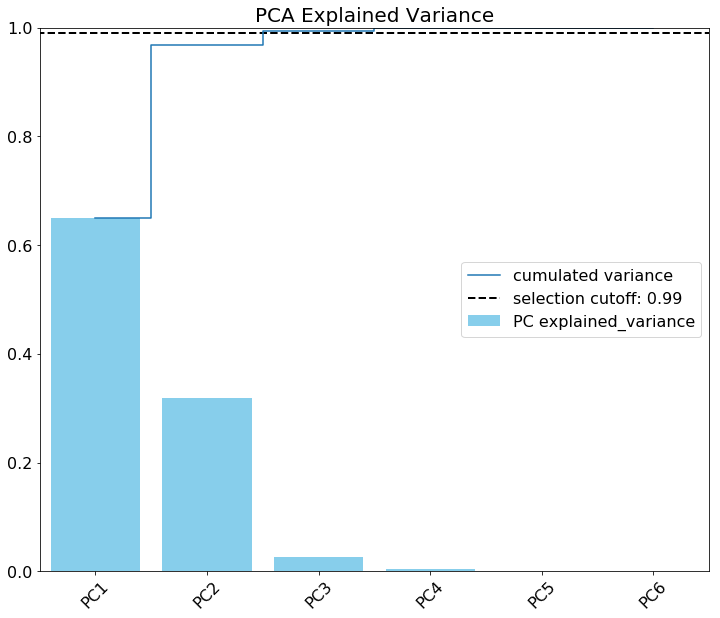

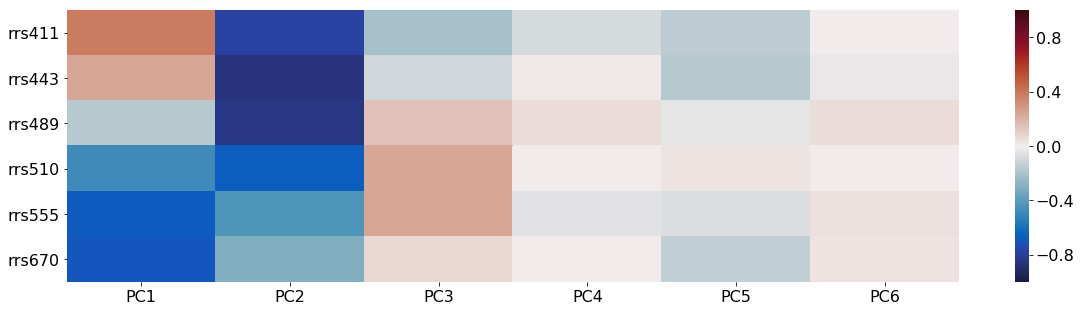

In [12]:
pca_log = PCA()
pca_log_data = pca_log.fit_transform(df_l.as_matrix())
PlotPCARes(pca_log, threshold=0.99, alpha=0.9, num_pca_disp=pca_log_data.shape[1])
PlotCrossCorr(pca_log_data)

In [13]:
for i in range(1, 7):
    loc = df_l.columns.get_loc('rrs670')
    df_l.insert(loc+i, f'PC{i}', pca_log_data[:,i-1])

Here is the comparison to pca of raw reflectances:

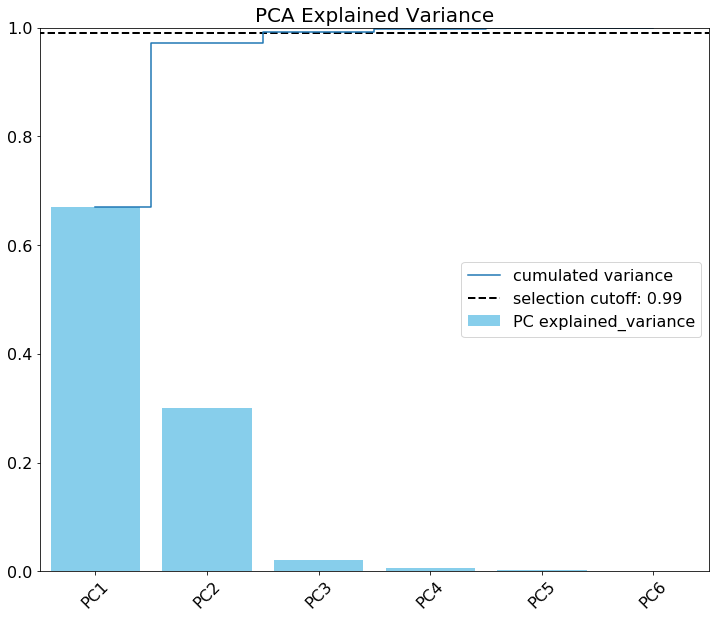

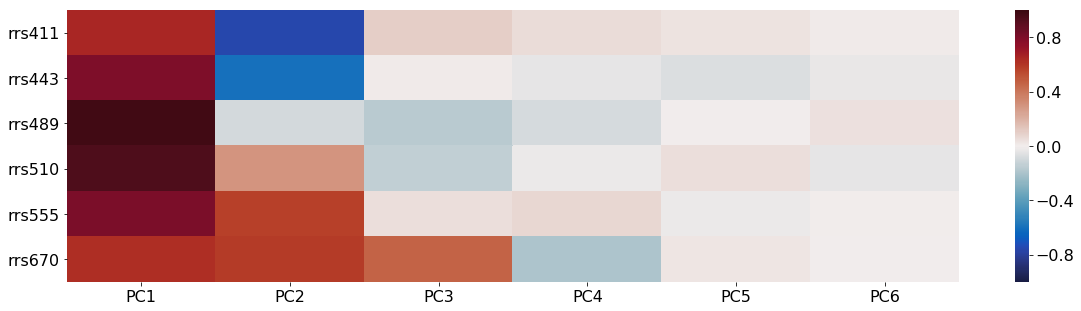

In [14]:
pca_ = PCA()
pca_data = pca_.fit_transform(df_.filter(regex='rrs').as_matrix())
PlotPCARes(pca_, threshold=0.99, alpha=0.9, num_pca_disp=pca_data.shape[1])
PlotCrossCorr(pca_data)

In [15]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3603 entries, 0 to 4458
Data columns (total 12 columns):
rrs411    3603 non-null float64
rrs443    3603 non-null float64
rrs489    3603 non-null float64
rrs510    3603 non-null float64
rrs555    3603 non-null float64
rrs670    3603 non-null float64
PC1       3603 non-null float64
PC2       3603 non-null float64
PC3       3603 non-null float64
PC4       3603 non-null float64
PC5       3603 non-null float64
PC6       3603 non-null float64
dtypes: float64(12)
memory usage: 525.9 KB


Assigning index to Province

In [16]:
df_.insert(df_.columns.get_loc('Province')+1, 'ProvIdx',
           df_.Province.astype('category').cat.codes)

In [17]:
df_.drop(['ProvCode', 'ProvCat'], axis=1, inplace=True)
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3603 entries, 0 to 4458
Data columns (total 29 columns):
id              3603 non-null object
datetime        3603 non-null datetime64[ns]
doy             3603 non-null float64
lat             3603 non-null float64
lon             3603 non-null float64
Province        3603 non-null object
ProvIdx         3603 non-null int8
Biome           3603 non-null object
BiomCat         3603 non-null int8
etopo2          3603 non-null float64
oisst           3603 non-null float64
woa_sst_mean    2143 non-null float64
woa_sst_se      2143 non-null float64
woa_sal_mean    2138 non-null float64
woa_sal_se      2138 non-null float64
rrs411          3603 non-null float64
rrs443          3603 non-null float64
rrs489          3603 non-null float64
rrs510          3603 non-null float64
rrs555          3603 non-null float64
rrs670          3603 non-null float64
mxBl            3603 non-null float64
mxBlId          3603 non-null object
mxBlCat         3603 n

In [18]:
df_l[['id', 'Province', 'ProvIdx', 'etopo2', 'oisst',
     'is_hplc']] = df_[['id', 'Province', 'ProvIdx','etopo2', 'oisst', 'is_hplc']]
df_l['chl'] = np.log10(df_.chl)

In [20]:
df_l.dropna(inplace=True)

In [21]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3311 entries, 0 to 4458
Data columns (total 19 columns):
rrs411      3311 non-null float64
rrs443      3311 non-null float64
rrs489      3311 non-null float64
rrs510      3311 non-null float64
rrs555      3311 non-null float64
rrs670      3311 non-null float64
PC1         3311 non-null float64
PC2         3311 non-null float64
PC3         3311 non-null float64
PC4         3311 non-null float64
PC5         3311 non-null float64
PC6         3311 non-null float64
id          3311 non-null object
Province    3311 non-null object
ProvIdx     3311 non-null int8
etopo2      3311 non-null float64
oisst       3311 non-null float64
is_hplc     3311 non-null float64
chl         3311 non-null float64
dtypes: float64(16), int8(1), object(2)
memory usage: 494.7+ KB


In [22]:
df_l.describe().T

,count,mean,std,min,25%,50%,75%,max
rrs411,3311.0,-2.408172,0.326966,-4.282273,-2.595471,-2.392028,-2.177275,-1.514266
rrs443,3311.0,-2.415298,0.289842,-3.718891,-2.571452,-2.403485,-2.212183,-1.434509
rrs489,3311.0,-2.389852,0.231960,-3.545005,-2.510675,-2.376747,-2.244050,-1.195076
rrs510,3311.0,-2.460284,0.216113,-3.581435,-2.574543,-2.481263,-2.386559,-1.109348
rrs555,3311.0,-2.600266,0.302411,-3.681273,-2.805613,-2.684311,-2.466319,-0.963100
rrs670,3311.0,-3.569523,0.638160,-6.000000,-3.983877,-3.689428,-3.221012,-1.557505
PC1,3311.0,-0.009290,0.713313,-2.280088,-0.430879,0.111475,0.492285,2.390972
PC2,3311.0,-0.002922,0.505232,-2.498980,-0.316617,-0.018179,0.265389,2.663788
PC3,3311.0,-0.000341,0.144703,-0.638281,-0.084041,-0.014178,0.064704,1.121505
PC4,3311.0,0.000088,0.063026,-0.302540,-0.027348,0.005500,0.035222,0.548890


In [24]:
df_l = df_l[['id', 'Province', 'ProvIdx', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
            'etopo2', 'oisst', 'is_hplc', 'chl']]

In [25]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3311 entries, 0 to 4458
Data columns (total 13 columns):
id          3311 non-null object
Province    3311 non-null object
ProvIdx     3311 non-null int8
PC1         3311 non-null float64
PC2         3311 non-null float64
PC3         3311 non-null float64
PC4         3311 non-null float64
PC5         3311 non-null float64
PC6         3311 non-null float64
etopo2      3311 non-null float64
oisst       3311 non-null float64
is_hplc     3311 non-null float64
chl         3311 non-null float64
dtypes: float64(10), int8(1), object(2)
memory usage: 339.5+ KB


In [26]:
df_log = df_l

In [27]:
df_log.to_pickle('./pickleJar/df_log_w_pca.pkl')